<a href="https://colab.research.google.com/github/tanmayasang/What-s-Cooking-Kaggle-Challenge/blob/main/What's_cooking%3F_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What's cooking? - A classification model with evaluation**


### **Table of Contents**

 

1.   Problem Statement
2.   Data Exploration
3.   Data Science Objectives
4.   Key Results
>*   Neural Network 
>*   Logistic Regression
>*   Support Vector Classifier
>*   Random Forest Classifier




5.   Key Activities
6.   Canvas




### **1. Problem Statement**

>Given the ingredients, build a model which can predict the cuisine those ingredients belong to based on a training set. This model can be integrated with food delivery and restaurant rating apps to suggest dishes by cuisine, and to help consumers in deciding the meal they wish to consume based on ingredients they are craving!

### **2. Data Exploration**

>The data is obtained from Kaggle in json format, which introduces a wide range of recipes. The training set includes an ID number, the ingredients that are being used, and the origins of each dish. Some of the listed cuisines are from the southern US, India, Italy, and Jamaica, etc. There is also a test set that is identical to the training set except that cuisine is withheld.


In [ ]:
#Imports
import json
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Load dataset
df_train = pd.read_json('/content/train.json')
df_train

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


**Data visualization:**

In [ ]:
#Let's print a concise summary of the dataframe, and check if we have any null values
#Viewing information about the data
df_train.info()
#Obtaining count of unique classes
uniqueCuisine = df_train['cuisine'].unique()
print("\n The number of unique cuisines =", len(uniqueCuisine))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB

 The number of unique cuisines = 20


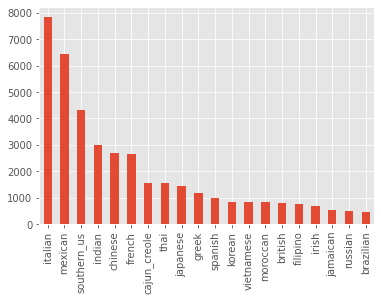

In [ ]:
#Viewing the distribution of cuisines in the dataset and the number of cuisines we have
%matplotlib inline
plt.style.use('ggplot')
df_train['cuisine'].value_counts().plot(kind='bar')

From above graph we can see that Italian, Mexican and Southern_us recepies are occurring the most number of times in the dataset

In [ ]:
#Now, let's visualize the most frequent ingredients which are present in each cuisine.
#For this we will use Python counter objects

from collections import Counter
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)


Let's view the top 10 most frequent ingredients in mexican cuisine

In [ ]:
counters['mexican'].most_common(10)

[('salt', 2720),
 ('onions', 1493),
 ('ground cumin', 1346),
 ('garlic', 1317),
 ('olive oil', 1289),
 ('chili powder', 1236),
 ('jalapeno chilies', 1146),
 ('sour cream', 1076),
 ('avocado', 1044),
 ('corn tortillas', 946)]

In [ ]:
#Lets now store the top 10 ingredients for each cuisine in a new dataframe to get a better idea overall
top10ing = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10ing

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


Let's extract all unique ingredients possible from the dataframe above

In [ ]:
#Visualizing the unique ingredients present in the dataframe of top 10 ingredients 
unique = np.unique(top10ing.values.ravel())
unique

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
       'ginger', 'grated parmesan cheese', 'green bell pepper',
       'green onions', 'ground allspice', 'ground black pepper',
       'ground cinnamon', 'ground cumin', 'ground ginger',
       'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime',
       'milk', 'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
       'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
       'scallions', 'sesame oil', 'sesame seeds', 'shallots',
       'sour cream', 'soy sauce', 'sugar', 'tomatoes', 'un

*Let's visualize the frequency of above unique ingredients in all cuisines using a subplot * 

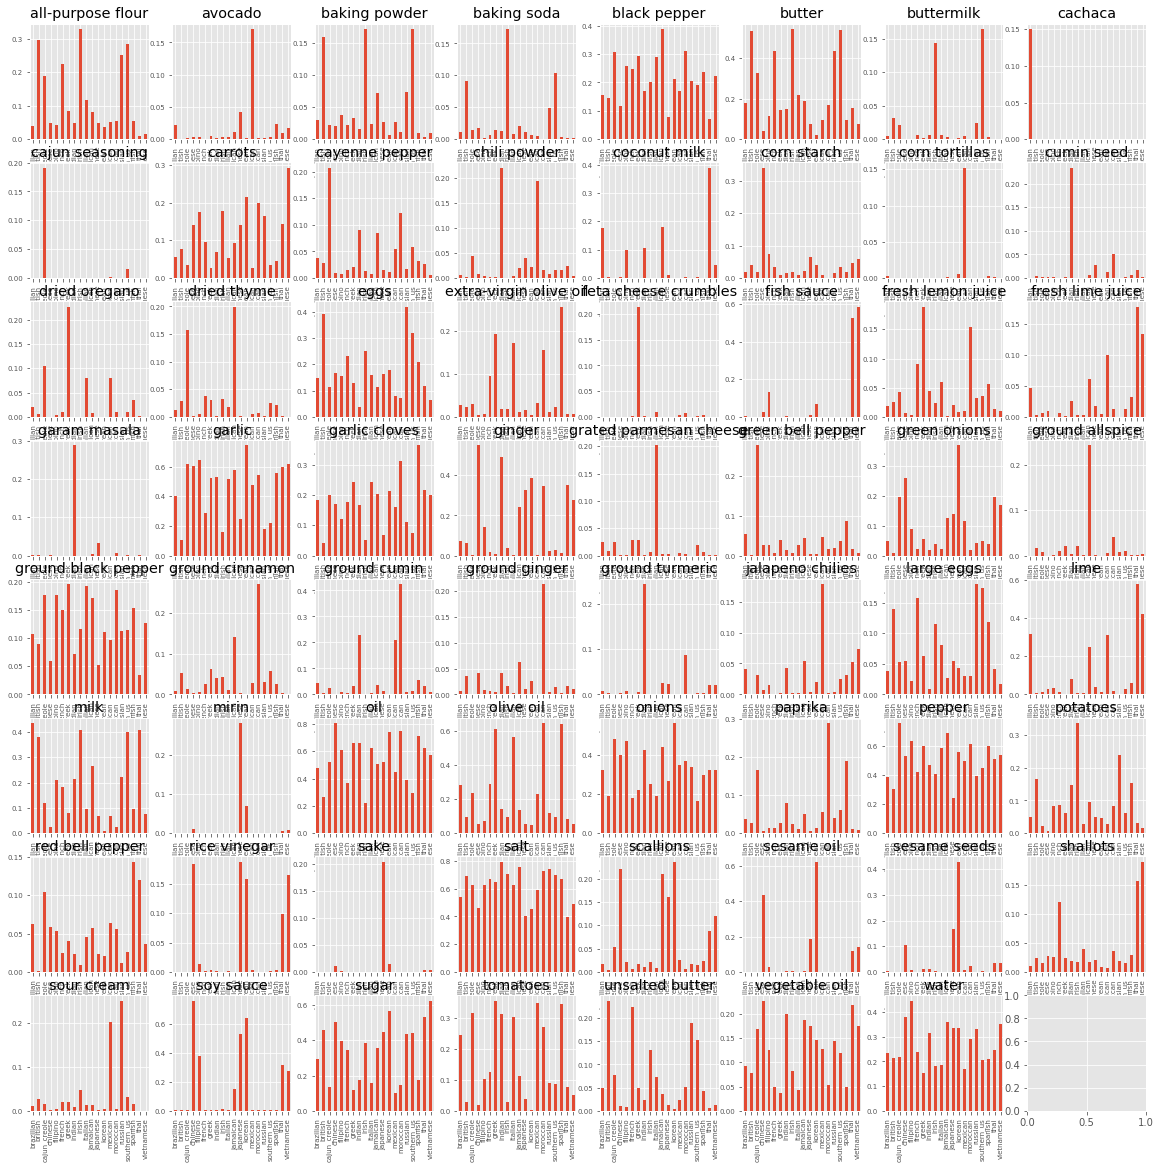

In [ ]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
#Lets visualize this as a subplot
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = df_train['all_ingredients'].str.contains(ingredient)
    relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

We can observe that tomatoes and sesame seeds occur frquently for all cuisines

### **3. Data Science Objectives**

>Mining this unstructured cuisine ingredient and cuisine data can help restaurant and delivery apps organize and gain business insights from customers and their interests. A couple models can be considered in the data training process, such as Random Forest, SVM, Logistic Regression, or clustering methods etc. While training on these models, tuning parameters can be challenging, since parameters tuning plays a huge role in result accuracy, precision, and other evaluation metrics. Our results are expected to achieve a satisfied accuracy, precision, F1 score, confusion matrix, etc. The success rate can be determined by comparing the estimated results from our model to the answers listed in the training set. We are expecting an accuracy rate between 80-90%. 

### **4. Key Results**

#### 1. Neural Network results and metrics

###### Data pre-processing

In [ ]:
#remove unnecessary symbols and convert all strings to lowercase
df_train.ingredients = df_train.ingredients.astype('str')
df_train.ingredients = df_train.ingredients.str.replace("["," ")
df_train.ingredients = df_train.ingredients.str.replace("]"," ")
df_train.ingredients = df_train.ingredients.str.replace("'"," ")
df_train.ingredients = df_train.ingredients.str.replace(","," ")
df_train.ingredients = df_train.ingredients.str.lower()

#tokenize data
df_train.ingredients = df_train.ingredients.apply(lambda x: word_tokenize(x))
lemmatizer = WordNetLemmatizer()
def lemmat(wor):
    l = []
    for i in wor:
        l.append(lemmatizer.lemmatize(i))
    return l
df_train.ingredients = df_train.ingredients.apply(lemmat)


#Lemmatization converted it back to list, so change to str again and remove the unncessary words.
df_train.ingredients = df_train.ingredients.astype('str')
df_train.ingredients = df_train.ingredients.str.replace("["," ")
df_train.ingredients = df_train.ingredients.str.replace("]"," ")
df_train.ingredients = df_train.ingredients.str.replace("'"," ")
df_train.ingredients = df_train.ingredients.str.replace(","," ")

###### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['ingredients'], df_train.cuisine, stratify=df_train.cuisine, test_size=0.3)

###### Vectorization

In [ ]:
vectorizer = TfidfVectorizer(binary = True).fit(X_train.values)
X_train = vectorizer.transform(X_train.values)

###### Apply SVD/PCA

In [ ]:
var=[]
for n in np.linspace(100, 1000, num=10).astype(int):
  svd = TruncatedSVD(n_components=n, random_state=42)
  svd = svd.fit(X_train)
  var.append(svd.explained_variance_ratio_.sum())

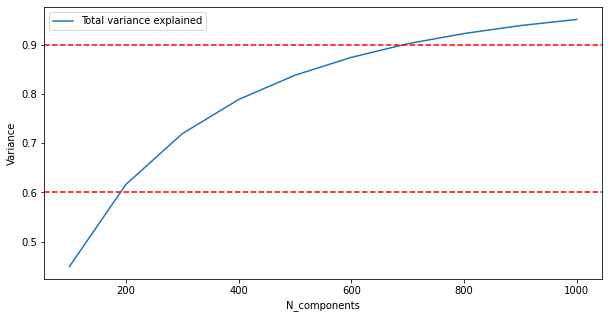

In [ ]:
plt.figure(figsize=(10,5))

plt.ylabel('Variance')
plt.xlabel('N_components')
plt.plot(np.linspace(100, 1000, num=10),var, label='Total variance explained')
plt.axhline(y = 0.6, color = 'r', linestyle = '--')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.legend(loc='best')
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=1000, random_state=42)
svd = svd.fit(X_train)
print(f"Total variance explained: {svd.explained_variance_ratio_.sum():.2f}")

Total variance explained: 0.95



>Using 1000 n_components, since it still explains 95% varriances of data, reducing dimension: 6700+ -----> 1000

In [ ]:
X_svd = svd.transform(X_train)
X_test = vectorizer.transform(X_test.values)
X_test_svd = svd.transform(X_test)
y_train= pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
classes = y_train.columns
y_train = y_train.values
y_test = y_test.values
no_of_classes = len(classes)

###### Model preparation and Training

In [ ]:
input_dim = 1000

model = Sequential()

#1st NN layer
model.add(Dense(100,input_dim = input_dim))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


#2nd NN layer
model.add(Dense(40))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout (0.25))


#out put layer
model.add(Dense(no_of_classes, activation='softmax'))


opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               100100    
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 100)               0         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 40)                4040      
                                                                 
 batch_normalization_3 (Batc  (None, 40)               160       
 hNormalization)                                      

In [ ]:
checkpoint = ModelCheckpoint("./model.nn", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]


model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])
batch_size=128
epochs = 30
process = model.fit(X_svd,y_train,validation_data=(X_test_svd, y_test),epochs=epochs,callbacks=callbacks_list)

Epoch 1/30
863/871 [============================>.] - ETA: 0s - loss: 1.5640 - accuracy: 0.5660
Epoch 00001: val_accuracy improved from -inf to 0.73469, saving model to ./model.nn
INFO:tensorflow:Assets written to: ./model.nn/assets
871/871 [==============================] - 6s 6ms/step - loss: 1.5595 - accuracy: 0.5669 - val_loss: 0.9210 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 2/30
864/871 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.7164
Epoch 00002: val_accuracy improved from 0.73469 to 0.76033, saving model to ./model.nn
INFO:tensorflow:Assets written to: ./model.nn/assets
871/871 [==============================] - 5s 6ms/step - loss: 0.9879 - accuracy: 0.7165 - val_loss: 0.7971 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 3/30
861/871 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.7466
Epoch 00003: val_accuracy improved from 0.76033 to 0.77265, saving model to ./model.nn
INFO:tensorflow:Assets written to: ./model.nn/assets
871/871

###### Evaluation

Train and Test Loss/Accuracy

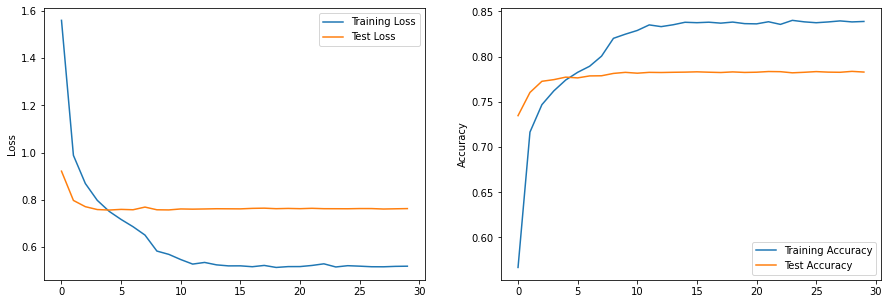

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(process.history['loss'], label='Training Loss')
plt.plot(process.history['val_loss'], label='Test Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(process.history['accuracy'], label='Training Accuracy')
plt.plot(process.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
model.load_weights("./model.nn")

Classification Report

In [ ]:
Y_pred = model.predict(X_test_svd, no_of_classes // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print('Classification Report')
target_names = classes.to_list()
print(classification_report(y_test_class, y_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

   brazilian       0.74      0.54      0.63       140
     british       0.59      0.47      0.52       241
cajun_creole       0.78      0.69      0.73       464
     chinese       0.78      0.86      0.82       802
    filipino       0.69      0.66      0.67       226
      french       0.60      0.63      0.62       794
       greek       0.78      0.68      0.73       352
      indian       0.86      0.91      0.88       901
       irish       0.60      0.59      0.59       200
     italian       0.82      0.88      0.85      2352
    jamaican       0.85      0.70      0.76       158
    japanese       0.79      0.70      0.74       427
      korean       0.79      0.73      0.76       249
     mexican       0.90      0.92      0.91      1932
    moroccan       0.78      0.80      0.79       246
     russian       0.59      0.48      0.53       147
 southern_us       0.74      0.77      0.75      1296
     

Confusion matrix

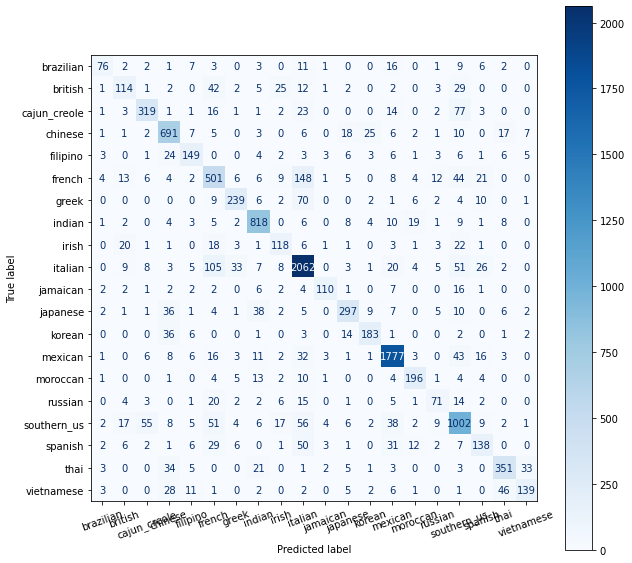

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
plot_confusion_matrix(y_test_class, y_pred, target_names) 

#### 2. Logistic Regression

###### Data preprocessing

In [ ]:
#Follow the preprocess of PCA/SVD application described in Neural Network model

X_svd = svd.transform(X_train)
X_test = vectorizer.transform(X_test.values)
X_test_svd = svd.transform(X_test)
encoder = preprocessing.LabelEncoder() 
y_train_enc= encoder.fit_transform(y_train)
y_test_enc= encoder.transform(y_test)

###### Model Preparation and Training

In [ ]:
lr_model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
lr_space = dict()
lr_space['solver'] = ['newton-cg', 'lbfgs']
lr_space['penalty'] = ['l2']
lr_space['C'] = [1e-1, 1, 10]
lr_search = GridSearchCV(lr_model, lr_space, scoring='accuracy', n_jobs=-1, cv=cv)
lr_result = lr_search.fit(X_svd, y_train_enc)

In [ ]:
print('Best Score: %s' % lr_result.best_score_)
print('Best Hyperparameters: %s' % lr_result.best_params_)

Best Score: 0.7748884617329511
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


###### Evaluation

In [ ]:
besr_lr = lr_result.best_estimator_
y_pred_enc= besr_lr.predict(X_test_svd)
print('Test Accuracy: %s' % accuracy_score(y_test_enc, y_pred_enc))

Test Accuracy: 0.7851336629514791


Classification report

In [ ]:
print('Classification Report')
target_names = encoder.classes_
print(classification_report(y_test_enc, y_pred_enc, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   brazilian       0.74      0.50      0.60       140
     british       0.55      0.45      0.49       241
cajun_creole       0.76      0.72      0.74       464
     chinese       0.78      0.85      0.81       802
    filipino       0.72      0.62      0.67       226
      french       0.61      0.62      0.61       794
       greek       0.78      0.73      0.76       352
      indian       0.87      0.89      0.88       901
       irish       0.63      0.56      0.59       200
     italian       0.82      0.89      0.85      2352
    jamaican       0.84      0.74      0.79       158
    japanese       0.78      0.73      0.75       427
      korean       0.80      0.69      0.74       249
     mexican       0.91      0.92      0.92      1932
    moroccan       0.81      0.74      0.77       246
     russian       0.55      0.46      0.50       147
 southern_us       0.72      0.78      0.75      1296
     

Confusion matrix

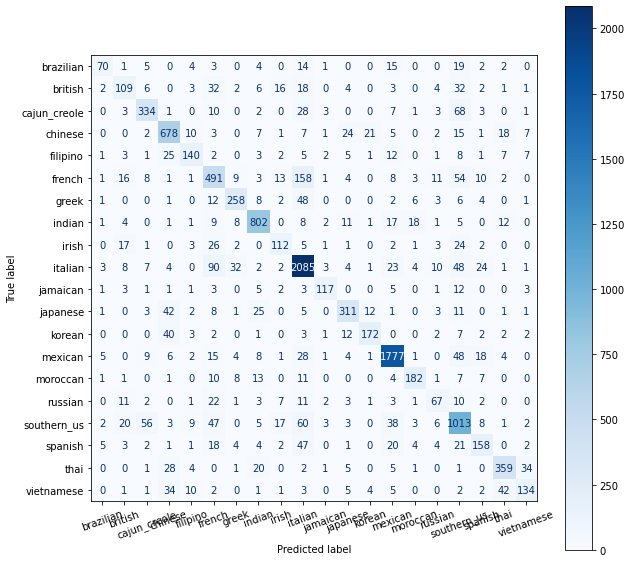

In [ ]:
plot_confusion_matrix(y_test_enc, y_pred_enc, target_names) 

#### 3. Support Vector Classfier

###### Data Preprocessing

In [ ]:
# read data
train = json.load(open('/content/train.json'))

#Convert ingredients to text
train_as_text = [' '.join(sample['ingredients']).lower() for sample in train]
train_cuisine = [sample['cuisine'] for sample in train]

In [ ]:
#Train test split
X_train,X_test,y_train,y_test = train_test_split(train_as_text, train_cuisine,stratify = train_cuisine,test_size = 0.3)

###### Vectorization

In [ ]:
tfidf = TfidfVectorizer(binary=True)
lbl_enc = LabelEncoder()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_test = X_test.astype('float16')
y_train = lbl_enc.fit_transform(y_train)
y_test = lbl_enc.transform(y_test)

In [ ]:
print("X_train sample:%d, X_train features: %d" %X_train.shape)
print("X_test sample:%d, X_test features: %d" %X_test.shape)
print("y_train length: %d" %len(y_train))
print("y_test length:%d" %len(y_test))

X_train sample:27841, X_train features: 2813
X_test sample:11933, X_test features: 2813
y_train length: 27841
y_test length:11933


###### SVM

In [ ]:
clf = SVC(C=100, gamma=1, coef0=1,verbose=True)
model = OneVsRestClassifier(clf, n_jobs=1)
model.fit(X_train,y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

OneVsRestClassifier(estimator=SVC(C=100, coef0=1, gamma=1, verbose=True),
                    n_jobs=1)

###### Evaluation

Accuracy score

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred))

Accuracy: 0.8111120422358167


*Classification* report

In [ ]:
print('Classification Report')
target_names = lbl_enc.classes_
print(classification_report(y_test,y_pred,target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   brazilian       0.78      0.59      0.67       140
     british       0.64      0.49      0.56       241
cajun_creole       0.79      0.75      0.77       464
     chinese       0.81      0.87      0.83       802
    filipino       0.78      0.67      0.72       226
      french       0.63      0.64      0.64       794
       greek       0.80      0.75      0.78       352
      indian       0.87      0.93      0.90       901
       irish       0.69      0.58      0.63       200
     italian       0.83      0.90      0.86      2352
    jamaican       0.91      0.75      0.82       158
    japanese       0.83      0.70      0.76       427
      korean       0.85      0.82      0.84       249
     mexican       0.91      0.93      0.92      1932
    moroccan       0.86      0.81      0.83       246
     russian       0.72      0.53      0.61       147
 southern_us       0.77      0.82      0.79      1296
     

Confusion matrix

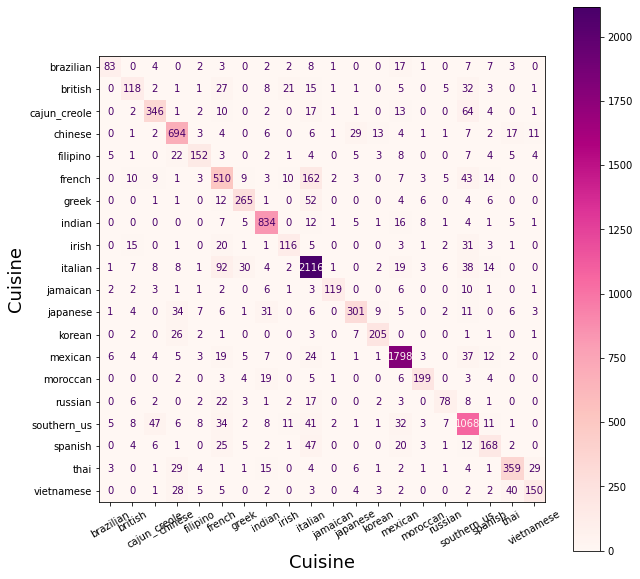

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10,10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'RdPu', ax = ax)
    plt.xticks(rotation = 30)
    plt.xlabel('Cuisine',fontsize = 18)
    plt.ylabel('Cuisine',fontsize = 18)
plot_confusion_matrix(y_test,y_pred,target_names)

#### 4. Random Forest Classifier

###### Data Preprocessing

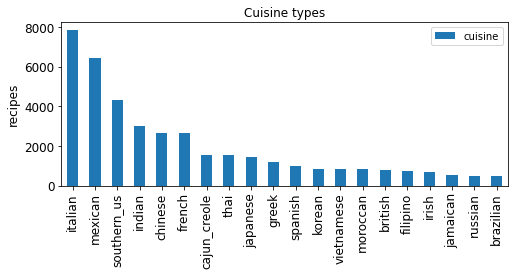

In [ ]:
import pandas
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
import numpy as np
import random
import gc

train_df=pandas.read_json(open('/content/train.json'))

ax = train_df['cuisine'].value_counts().plot(kind='bar', title ="Cuisine types", figsize=(8, 3), legend=True, fontsize=12)
ax.set_ylabel("recipes", fontsize=12)
plt.show()


Train - Test balance: As evident from chart above, the data is not evenly distributed, which means there is a chance that some cuisines will be represented more often(example Italian) in our training data, and some would be under represented(example Brazilian). Hence we need to split data evenly for each cuisine type. We will drop some data from over-represented cuisines.



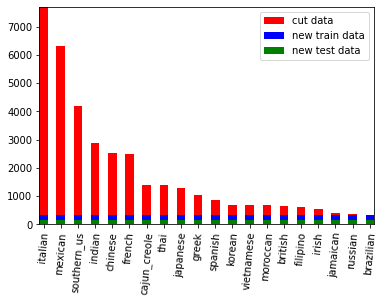

In [ ]:
new_test_df=pandas.DataFrame()
new_train_df=pandas.DataFrame()
cut_df=pandas.DataFrame()
for cuisine in train_df['cuisine'].drop_duplicates().values :
    temp=pandas.DataFrame()
    temp=train_df[train_df['cuisine']==cuisine]
    rows = random.sample(list(temp.index), round(0.3*467))
    new_test_df=new_test_df.append(temp.loc[rows])
    cut_df=cut_df.append(temp.drop(rows))
    new_train_df=new_train_df.append(temp.drop(rows).sample(round(0.7*467)))
del temp

ax=plt.subplot()
CuisineCall = list(range(0,len(cut_df['cuisine'].value_counts().index)))
LABELS=cut_df['cuisine'].value_counts().index
ax.bar(CuisineCall,cut_df['cuisine'].value_counts(),width=0.5,color='r',align='center',label='cut data')
ax.bar(CuisineCall,new_train_df['cuisine'].value_counts(),width=0.5,color='b',align='center', label='new train data')
ax.bar(CuisineCall,new_test_df['cuisine'].value_counts(),width=0.5,color='g',align='center',label='new test data')
plt.xticks(CuisineCall, LABELS,rotation=85)
ax.autoscale(tight=True)
plt.legend()

plt.show()

###### One Hot Encoding

We have ingredients as list of values which we need to transpose as columns of 1's or 0's to mark their presence in the cuisine type. We will use the one-hot encoding technique. 

In [ ]:
try: 
    del train_df
except:pass;gc.collect()

new_ingredients=new_train_df.ingredients
rawlist=[item for sublist in new_ingredients.ravel() for item in sublist] #convert the ingredients list of lists into a list
ingredients=list(set(rawlist)) #remove duplicates


ing = ingredients[0]
from tqdm import tqdm
for ing in tqdm(ingredients):
    vector=[]
    # loop for train data
    for recipe in new_train_df.ingredients: 
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    new_train_df[ing]=pandas.Series(vector,index=new_train_df.index) # Adds column containing 0 and 1's for this ingredient
    
    # loop for test data
    vector=[]
    for recipe in new_test_df.ingredients:
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    new_test_df[ing]=pandas.Series(vector,index=new_test_df.index) # Adds column containing 0 and 1's for this ingredient
   
    # loop for cut data
    vector=[]
    for recipe in cut_df.ingredients:
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    cut_df[ing]=pandas.Series(vector,index=cut_df.index) # Adds column containing 0 and 1's for this ingredient
# useless columns removal
new_train_df=new_train_df.drop('ingredients',1)
new_train_df=new_train_df.drop('id',1)

new_test_df=new_test_df.drop('ingredients',1)
new_test_df=new_test_df.drop('id',1)

cut_df=cut_df.drop('ingredients',1)
cut_df=cut_df.drop('id',1)

new_train_df.head()

100%|██████████| 3826/3826 [04:37<00:00, 13.79it/s]


,cuisine,quinces,fish balls,vanilla wafers,dried udon,challa,pasta rotel,dry coconut,bone-in chicken breasts,black sesame seeds,toasted almonds,candy sprinkles,white asparagus,fresh orange,Kewpie Mayonnaise,cumin,glace de viande,dinosaur kale,rooster,hominy,whole wheat couscous,hen,shredded romano cheese,panang curry paste,boneless chicken breast,glutinous rice flour,unsweetened vanilla almond milk,Guinness Lager,whole wheat penne pasta,caraway seeds,sweet mini bells,salmon sashimi,truffle oil,pork roast,angel food cake,uncle bens,amaranth,frozen shelled edamame,acai juice,evaporated milk,...,black beans,taco toppings,Pam Cooking Spray,croutons,steak sauce,jam,meat loaf mixture,essence seasoning,shiro miso,fresh cod,chinese cabbage,pink salmon,white sandwich bread,celery seed,quick-cooking oats,champagne vinegar,whole grain mustard,fronds,okra pods,pork sirloin,ginger root,hemp seeds,Kikkoman Soy Sauce,shredded zucchini,mixed peel,pectin,vanilla bean paste,ground lamb,33% less sodium smoked fully cooked ham,burdock,veggies,peperoncino,tenderloin steaks,pork bouillon cube,serrano chilies,seafood base,white truffle oil,Knox unflavored gelatin,cracked black pepper,sparkling sugar
3951,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
23188,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
31782,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1471,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16348,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###### Model Preparation and Training

In [ ]:
try: 
    X_train=new_train_df.drop('cuisine',axis=1)
    Y_train=new_train_df['cuisine']
    X_test=new_test_df.drop('cuisine',axis=1)
    Y_test=new_test_df['cuisine']
    X_cut=cut_df.drop('cuisine',axis=1)
    Y_cut=cut_df['cuisine']
    del new_train_df
    del new_test_df
    del new_ingredients
    del rawlist
    del ingredients
    del vector
except:pass;gc.collect()

from sklearn import metrics
forest=RFC(n_estimators=10,max_features=10)
forest.fit(X_train,Y_train)
output=forest.predict(X_test)
metrics.accuracy_score(Y_test, output)

0.4967857142857143

###### Evaluation

We have taken 10 estimators and 10 features for the classifier. We would like to see the performance of model for different number of estimators. We will try model for 50 estimators.

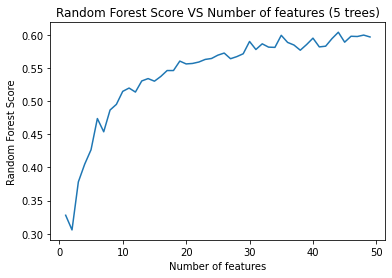

In [ ]:
opt_table_n_features=list()
n_estimators=5
n_features=50
for i in range(1,n_features):
    forest=RFC(n_estimators=i,max_features=n_features)
    forest.fit(X_train,Y_train)
    output=forest.predict(X_test)
    opt_table_n_features.append(metrics.accuracy_score(Y_test, output))
plt.plot(range(1,n_features), opt_table_n_features)
plt.xlabel('Number of features')
plt.ylabel('Random Forest Score')
plt.title('Random Forest Score VS Number of features (5 trees)')
plt.show()

We would perform the same activity for number of features.

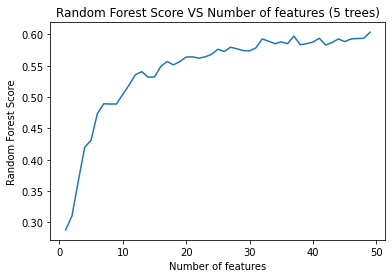

In [ ]:
opt_table_n_features=list()
n_estimators=5
n_features=50
for i in range(1,n_features):
    forest=RFC(n_estimators=i,max_features=n_features)
    forest.fit(X_train,Y_train)
    output=forest.predict(X_test)
    opt_table_n_features.append(metrics.accuracy_score(Y_test, output))
plt.plot(range(1,n_features), opt_table_n_features)
plt.xlabel('Number of features')
plt.ylabel('Random Forest Score')
plt.title('Random Forest Score VS Number of features (5 trees)')
plt.show()

As we could see, the estimators curve with score is performing well for higher number of estimators, whereas it plateaus at smaller values of features. Hence we would perform optimization on model with 5 features and 500 estimators

In [ ]:
forest=RFC(n_estimators=500,max_features=5)
forest.fit(X_train,Y_train)
output=forest.predict(X_test)
metrics.accuracy_score(Y_test, output)

0.6753571428571429

We would get important features from the forest model

[9.80194328e-06 7.02509773e-05 2.13300014e-05 ... 3.39702204e-05
 9.58153840e-04 5.08429493e-05]


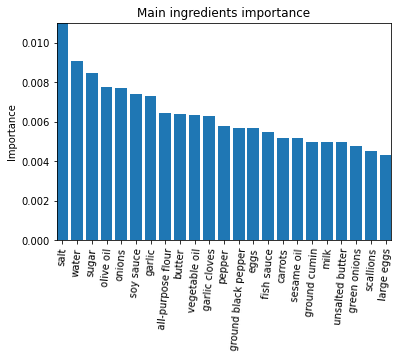

In [ ]:
importance = forest.feature_importances_
print(importance)
importance = pandas.DataFrame(importance, index=X_train.columns, columns=["Importance"])
importance_plot=importance.sort_values('Importance',ascending=False ).loc[importance['Importance']>0.004,:]
x = np.arange(len(importance_plot.index.values))
y = importance_plot.iloc[:, 0]
plt.bar(x, y,align='center')
plt.xticks(x,importance_plot.index.values,rotation=85)
plt.ylabel('Importance')
plt.title('Main ingredients importance')
plt.autoscale(tight=True)
plt.show()

As we can see from important features plot, the ingredients that are used for making decisions in the random forest classifier are salt, water, etc. which indicate that these features are weighted more than other ones in making prediction for cuisine.

### **5. Key Activities**

>We first obtain the training set and test set from Kaggle, then upload both sets as a dictionary. The data requires minimal work of preprocessing, as we only need to convert the ingredients into text data. To use SVM, we can then transform text to feature vectors so it can be used as input. In this case, TF and IDF should be used to vectorize the tokens in recipes. Then, we can implement the SVM algorithm alone with a type of multi-class classifications, such as One-Vs-Rest classifier, etc. Afterwards, we can make our prediction and submit our results into the submission folder. We can then calculate the accuracy rate by comparing our prediction and the data from the training set.

>1. Load Dataset and Data Overview. As shown in image below, the collected cuisine data set contains 3 attributes: id, cuisine, and ingredients. 

>2. Contents in the ingredients column will be the features, and cuisine column is the label classes. Before applying vectorization to ingredients, data was tokenized and “Lemmatization” was used to remove those unnecessary symbols, such as “tomato” and “tomatoes”. 

>3. Next, SVD/PCA technique was applied to reduce the data dimension, since the dataset ended up with more than 6700 columns after vectorization. The SVD/PCA results(shown in below images)suggest taking 1000 principal components, as it still has a total 95% variances explained.

>4. Model preparation


>>*   Neural Network Model. A neural network(shown in images below) with 2 hidden layers was implemented, with 100 neurons in 1 first layer, and 40 neurons in the second layer. The output layer dimension is the number of classes, and the final result was converted from probabilities of softmax function. Adam was used as the optimization, and 50 epochs were trained







>>*   Logistic regression. A regular grid search cross validation was performed to search the best parameters.






>>*   Support vector machine.By plotting the data points in n-dimensional space, the algorithm defines a hyperplane which segragates them, the data points lie on different side of the plane would be classified in different category.In this method, the data was only preprocessed using vectorization. **No PCA/SVD was applied.** Improve C from 10 to 100 only increased the accuracy score by 0.2%.




>>*  Random Forest Classifier - Based on the idea of decision trees, features are chosen at random to yield maximum distinct trees to introduce randomness and aggregate the result of each decision tree to yield class label as prediction, based on 'majority wins' analogy



**Result Comparison**

>Compare all four models we tested, we first eliminate Logistic Regression and Random Forest classifiers to be our final solution. This is because the grid search implemented in Logistic Regression is highly time consuming with a mediocre accuracy rate. The later model is dropped due to its low accuracy score.  
>Based on the good performance of SVM and Neural Network and time taken by each model, we would choose Neural Network as optimal model for the problem statement. The higher time taken by SVM and the accuracy score does not make the tradeoff worth it. In our case, the Neural Network model takes less than 10 minutes to apply PCA/SVD and train. The SVM, however, takes about 35 minutes to train. In practical, the large amount of datasets will only elongate the training time. A marginal difference of 2% in accuracy score does not significantly improve the user experience. Instead, the longer runntime will lose user's attention, and losing customers eventually. 
>This is also the adventage that our solution has comparing the existed solutions from others. Since Yummly, the host of this competetion on Kaggle, scores the answer purely based on the categorization accuracy, a number of teams would drop the consideration of model training time. However, we evaluate our solutions not just being used in this competetion, but in real world. Thus, the Neural Network classifer is our solution in a comprehensive view.

### **6. Canvas**

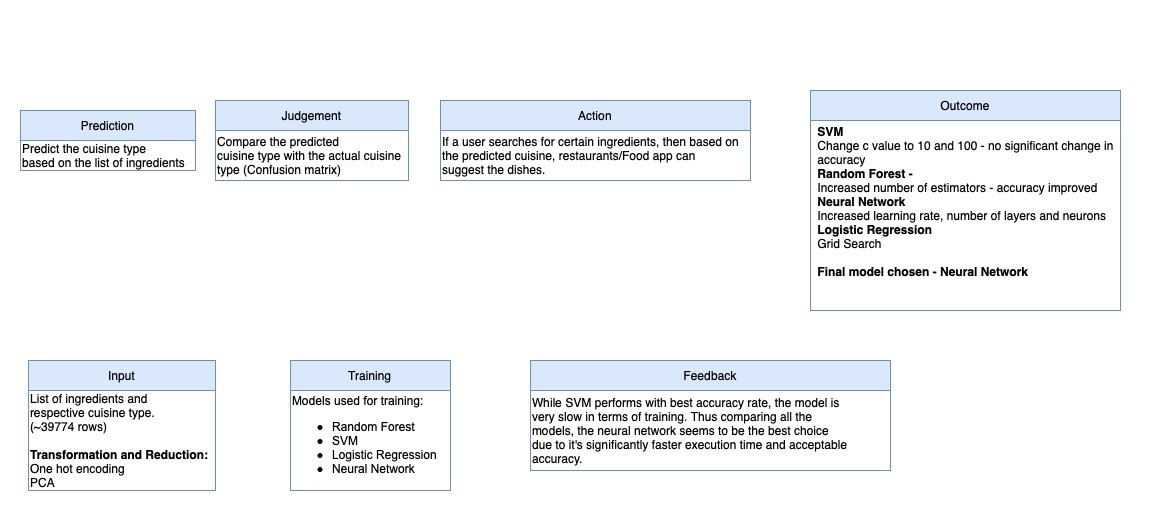

### **8. Reference**

>[1]       M. Svensson, K. Höök, and R. Cöster, “Designing and evaluating kalas: A social navigation system for food recipes,” ACM Trans. Comput.-Hum. Interact., vol. 12, no. 3, pp. 374–400, Sep. 2005, doi: 10.1145/1096737.1096739.

>[2]       P. Forbes and M. Zhu, “Content-boosted matrix factorization for recommender systems: experiments with recipe recommendation,” 2011. doi: 10.1145/2043932.2043979.

>[3]       H. Xie, L. Yu, and Q. Li, “A Hybrid Semantic Item Model for Recipe Search by Example,” in 2010 IEEE International Symposium on Multimedia, Dec. 2010, pp. 254–259. doi: 10.1109/ISM.2010.44.

>[4]       Y. Shidochi, T. Takahashi, I. Ide, and H. Murase, “Finding replaceable materials in cooking recipe texts considering characteristic cooking actions,” in Proceedings of the ACM multimedia 2009 workshop on Multimedia for cooking and eating activities - CEA ’09, Beijing, China, 2009, p. 9. doi: 10.1145/1630995.1630998.

>[5]       S. Jayaraman, T. Choudhury, and P. Kumar, “Analysis of classification models based on cuisine prediction using machine learning,” in 2017 International Conference On Smart Technologies For Smart Nation (SmartTechCon), Aug. 2017, pp. 1485–1490. doi: 10.1109/SmartTechCon.2017.8358611.